# Gas Monitoring Dataset - Exploratory Data Analysis

## Overview
This notebook provides a comprehensive yet concise exploratory analysis of the gas monitoring dataset. We analyze the raw data first to identify quality issues, then examine the cleaned data for feature selection and modeling insights.

---

## Section 1: Raw Data Loading & Initial Assessment

### Load the raw dataset from SQLite database

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Load raw data directly from database
conn = sqlite3.connect('data/gas_monitoring.db')
df_raw = pd.read_sql_query("SELECT * FROM gas_monitoring", conn)
conn.close()

# Basic information
print(f"Raw dataset shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")
print(f"\nData types:\n{df_raw.dtypes}")
print(f"\nFirst few rows:")
df_raw.head()

Raw dataset shape: (10000, 14)
Columns: ['Time of Day', 'Temperature', 'Humidity', 'CO2_InfraredSensor', 'CO2_ElectroChemicalSensor', 'MetalOxideSensor_Unit1', 'MetalOxideSensor_Unit2', 'MetalOxideSensor_Unit3', 'MetalOxideSensor_Unit4', 'CO_GasSensor', 'Session ID', 'HVAC Operation Mode', 'Ambient Light Level', 'Activity Level']

Data types:
Time of Day                   object
Temperature                  float64
Humidity                     float64
CO2_InfraredSensor           float64
CO2_ElectroChemicalSensor    float64
MetalOxideSensor_Unit1       float64
MetalOxideSensor_Unit2       float64
MetalOxideSensor_Unit3       float64
MetalOxideSensor_Unit4       float64
CO_GasSensor                  object
Session ID                     int64
HVAC Operation Mode           object
Ambient Light Level           object
Activity Level                object
dtype: object

First few rows:


,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level
0,morning,19.63,53.83,125.49,571.09,478.55,735.85,497.59,565.05,medium,7241,off,very_dim,Low Activity
1,morning,19.66,53.69,126.34,575.79,491.96,740.28,NaN,557.08,low,7241,ventilation_only,bright,Low Activity
2,night,20.95,54.12,119.34,556.53,437.50,718.34,NaN,612.62,medium,9385,off,None,Low Activity
3,morning,20.10,50.48,113.50,NaN,515.14,744.02,676.15,600.22,low,7241,eco_mode,very_bright,High Activity
4,morning,19.89,48.42,92.77,613.65,535.66,770.27,720.27,625.73,low,7241,Heating_active,moderate,Low Activity


## Section 2: Data Quality Assessment - Critical Issues

**Critical Finding - Duplicates:**
- Found duplicate rows that need removal
- Duplicates can skew analysis and model performance

In [2]:
print("=== DUPLICATE ANALYSIS ===")
duplicates = df_raw.duplicated()
print(f"Duplicate rows found: {duplicates.sum()}")
print(f"Percentage duplicated: {(duplicates.sum()/len(df_raw))*100:.2f}%")

if duplicates.sum() > 0:
    print("\nSample duplicate rows:")
    print(df_raw[duplicates].head())

=== DUPLICATE ANALYSIS ===
Duplicate rows found: 120
Percentage duplicated: 1.20%

Sample duplicate rows:
     Time of Day  Temperature  Humidity  CO2_InfraredSensor  \
587    afternoon        18.40     52.92              105.40   
598        night        20.21     54.76              126.95   
1108     morning        18.80     51.59              105.10   
1154     morning        17.90     44.69               64.59   
1567     evening        23.54     44.36              124.89   

      CO2_ElectroChemicalSensor  MetalOxideSensor_Unit1  \
587                      593.77                  502.01   
598                      543.23                  454.47   
1108                     614.08                  514.43   
1154                     628.18                  589.80   
1567                     592.95                  444.00   

      MetalOxideSensor_Unit2  MetalOxideSensor_Unit3  MetalOxideSensor_Unit4  \
587                   752.28                  711.66                  651.27   


### Examine target variable 
**Critical Finding - Inconsistent Target Variable:**
- Multiple variations of same categories (e.g., 'Low Activity', 'LowActivity', 'Low_Activity')
- Inconsistent naming conventions need standardization
- This would cause ML model to treat same categories as different classes

In [ ]:
activity_counts = df_raw['Activity Level'].value_counts()
print(activity_counts)

print(f"\nUnique values: {df_raw['Activity Level'].unique()}")
print(f"Total categories: {df_raw['Activity Level'].nunique()}")

# Check for inconsistent naming
unique_activities = df_raw['Activity Level'].unique()
for activity in unique_activities:
    print(f"'{activity}' - Length: {len(str(activity))}")

Activity Level
Low Activity         5231
Moderate Activity    2808
High Activity        1088
ModerateActivity      307
LowActivity           293
Low_Activity          273
Name: count, dtype: int64

Unique values: ['Low Activity' 'High Activity' 'Moderate Activity' 'ModerateActivity'
 'Low_Activity' 'LowActivity']
Total categories: 6
'Low Activity' - Length: 12
'High Activity' - Length: 13
'Moderate Activity' - Length: 17
'ModerateActivity' - Length: 16
'Low_Activity' - Length: 12
'LowActivity' - Length: 11


### Check for temperature anomalies
**Critical Finding - Temperature Anomalies:**
- Found temperatures > 100°C (unrealistic for indoor monitoring)
- Likely data entry errors or sensor calibration issues
- Appears to be off by factor of 10 (e.g., 250°C should be 25°C)

Temperature statistics:
count    10000.000000
mean        42.564132
std         74.350143
min         14.940000
25%         19.000000
50%         20.530000
75%         23.130000
max        298.930000
Name: Temperature, dtype: float64

Temperatures > 100°C: 805
Sample high temperature values:
8      292.59
23     292.40
37     293.66
49     293.59
64     295.06
83     292.55
117    297.97
124    296.77
125    297.15
133    297.52
Name: Temperature, dtype: float64


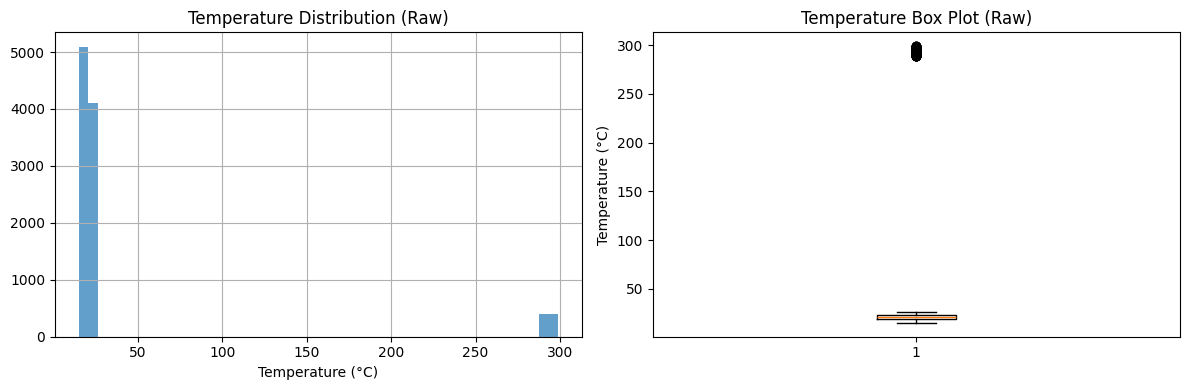

In [5]:
temp_stats = df_raw['Temperature'].describe()
print("Temperature statistics:")
print(temp_stats)

# Check for unrealistic temperature values
high_temp_mask = df_raw['Temperature'] > 100
high_temp_count = high_temp_mask.sum()
print(f"\nTemperatures > 100°C: {high_temp_count}")

if high_temp_count > 0:
    print("Sample high temperature values:")
    print(df_raw[high_temp_mask]['Temperature'].head(10))
    
    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    df_raw['Temperature'].hist(bins=50, alpha=0.7)
    plt.title('Temperature Distribution (Raw)')
    plt.xlabel('Temperature (°C)')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df_raw['Temperature'])
    plt.title('Temperature Box Plot (Raw)')
    plt.ylabel('Temperature (°C)')
    plt.tight_layout()
    plt.show()

### Check sensor values
**Critical Finding - Negative Sensor Values:**
- Sensor readings cannot be negative (humidity, CO2, metal oxide sensors)
- Indicates sensor malfunction or data transmission errors
- Need to replace with NaN for proper imputation

In [6]:
sensor_cols = ['Humidity', 'CO2_InfraredSensor', 'CO2_ElectroChemicalSensor', 
               'MetalOxideSensor_Unit1', 'MetalOxideSensor_Unit2', 
               'MetalOxideSensor_Unit3', 'MetalOxideSensor_Unit4']

negative_issues = {}
for col in sensor_cols:
    if col in df_raw.columns:
        negative_mask = df_raw[col] < 0
        negative_count = negative_mask.sum()
        if negative_count > 0:
            negative_issues[col] = negative_count
            print(f"{col}: {negative_count} negative values ({negative_count/len(df_raw)*100:.2f}%)")

if negative_issues:
    print(f"\nTotal columns with negative values: {len(negative_issues)}")
    
    # Show examples
    for col, count in negative_issues.items():
        print(f"\n{col} negative values sample:")
        print(df_raw[df_raw[col] < 0][col].head())

Humidity: 269 negative values (2.69%)
CO2_InfraredSensor: 22 negative values (0.22%)

Total columns with negative values: 2

Humidity negative values sample:
17    -18.66
118    -4.25
124   -33.97
201   -45.01
299   -39.82
Name: Humidity, dtype: float64

CO2_InfraredSensor negative values sample:
399     -4.35
1539    -6.63
1712   -12.61
2686    -8.01
3332   -13.21
Name: CO2_InfraredSensor, dtype: float64


### Examine HVAC category inconsistencies
**Finding - HVAC Inconsistencies:**
- Inconsistent formatting (underscores, spaces, capitalization)
- Same modes represented differently (e.g., 'cooling_active' vs 'cooling active')
- Need normalization for consistent categories

In [7]:
hvac_counts = df_raw['HVAC Operation Mode'].value_counts()
print("HVAC Operation Mode categories:")
print(hvac_counts)

print(f"\nUnique HVAC modes: {df_raw['HVAC Operation Mode'].nunique()}")
print("All unique values:")
for mode in df_raw['HVAC Operation Mode'].unique():
    print(f"'{mode}'")

HVAC Operation Mode categories:
HVAC Operation Mode
cooling_active      1504
maintenance_mode    1501
heating_active      1491
eco_mode            1437
ventilation_only    1435
off                 1429
COOLING_ACTIVE       120
OFF                  106
ECO_MODE             106
Off                  101
MAINTENANCE_MODE     101
VENTILATION_ONLY      99
HEATING_ACTIVE        88
Heating_Active        63
Ventilation_Only      53
Maintenance_Mode      51
Heating_active        49
Maintenance_mode      49
Eco_Mode              48
Eco_mode              48
Ventilation_only      42
Cooling_active        41
Cooling_Active        38
Name: count, dtype: int64

Unique HVAC modes: 23
All unique values:
'off'
'ventilation_only'
'eco_mode'
'Heating_active'
'heating_active'
'maintenance_mode'
'cooling_active'
'Eco_Mode'
'Cooling_Active'
'MAINTENANCE_MODE'
'Eco_mode'
'HEATING_ACTIVE'
'COOLING_ACTIVE'
'VENTILATION_ONLY'
'Ventilation_Only'
'Heating_Active'
'Off'
'ECO_MODE'
'Ventilation_only'
'OFF'
'Maintenan

### Missing data analysis
**Finding - large percentage of missing values**
- consider not using MetalOxideSensor_Unit3, Ambient Light Level as features
- above columns have high missing values >25%

In [9]:
missing_data = df_raw.isnull().sum()
missing_percent = (missing_data / len(df_raw)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print("Missing data summary:")
print(missing_df[missing_df['Missing Count'] > 0])

Missing data summary:
                           Missing Count  Missing Percentage
MetalOxideSensor_Unit3              2566               25.66
Ambient Light Level                 2532               25.32
CO_GasSensor                        1369               13.69
CO2_ElectroChemicalSensor            706                7.06


## Section 3: Data Cleaning 
**Cleaning Results:**
- Duplicates removed successfully
- Target variables standardized to 3 consistent categories
- Temperature anomalies fixed (values > 100°C corrected)
- Negative sensor values replaced with NaN for imputation
- HVAC categories normalized
- Missing values imputed appropriately

In [1]:
from src.data_preprocessing import load_and_clean_data

# Load cleaned data
df_clean, preprocessor = load_and_clean_data()

df_clean.head()

Starting data cleaning...
Original shape: (10000, 14)
Removed 120 duplicate rows
Fixing 804 temperature anomalies (values > 100°C)
Temperature range after correction: 14.9 to 29.9°C
Fixing 269 negative values in Humidity
Fixing 22 negative values in CO2_InfraredSensor
Standardized target categories: ['Low Activity' 'High Activity' 'Moderate Activity']
New distribution:
Activity Level
Low Activity         5722
Moderate Activity    3082
High Activity        1076
Name: count, dtype: int64
HVAC categories after normalization: ['cooling active', 'eco mode', 'heating active', 'maintenance mode', 'off', 'ventilation only']
HVAC distribution:
HVAC Operation Mode
maintenance mode    1684
cooling active      1683
heating active      1666
off                 1621
eco mode            1618
ventilation only    1608
Name: count, dtype: int64
Encoded Time of Day: {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
Encoded CO_GasSensor: {'extremely low': 0, 'low': 1, 'medium': 2, 'high': 3, 'extre

,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Ambient Light Level,Activity Level,HVAC_cooling active,HVAC_eco mode,HVAC_heating active,HVAC_maintenance mode,HVAC_off,HVAC_ventilation only,HVAC_nan
0,0,19.63,53.83,125.49,571.09,478.55,735.85,497.59,565.05,2.0,0.0,Low Activity,False,False,False,False,True,False,False
1,0,19.66,53.69,126.34,575.79,491.96,740.28,680.19,557.08,1.0,2.0,Low Activity,False,False,False,False,False,True,False
2,3,20.95,54.12,119.34,556.53,437.50,718.34,680.19,612.62,2.0,2.0,Low Activity,False,False,False,False,True,False,False
3,0,20.10,50.48,113.50,578.93,515.14,744.02,676.15,600.22,1.0,3.0,High Activity,False,True,False,False,False,False,False
4,0,19.89,48.42,92.77,613.65,535.66,770.27,720.27,625.73,1.0,1.0,Low Activity,False,False,True,False,False,False,False


## Section 4: Target Distribution Analysis 

**Class Imbalance Issues**

- Severely imbalanced dataset: 57.9% vs 31.2% vs 10.9%
- Stratified sampling must be implemented

Activity Level Distribution:
Low Activity: 5722 samples (57.9%)
Moderate Activity: 3082 samples (31.2%)
High Activity: 1076 samples (10.9%)


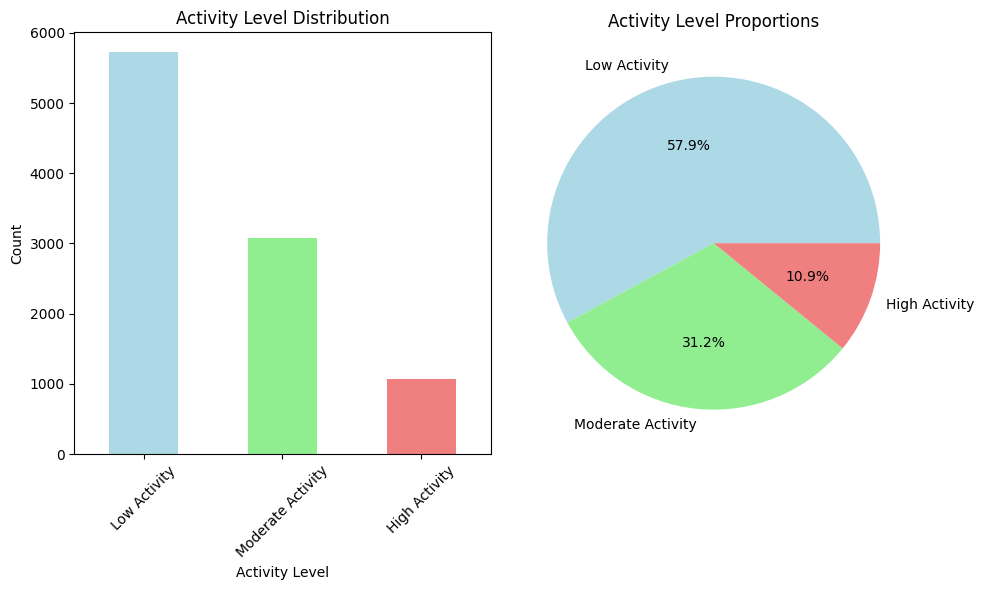

In [13]:
target_counts = df_clean['Activity Level'].value_counts()
target_pct = df_clean['Activity Level'].value_counts(normalize=True) * 100

print("Activity Level Distribution:")
for activity, count in target_counts.items():
    pct = target_pct[activity]
    print(f"{activity}: {count} samples ({pct:.1f}%)")

# Visualization
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
target_counts.plot(kind='bar', color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Activity Level Distribution')
plt.xlabel('Activity Level')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
target_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Activity Level Proportions')
plt.ylabel('')
plt.tight_layout()
plt.show()

## Section 5: Feature-Target Correlation Analysis

### Calculate correlations between features and target 

Features ranked by correlation strength with Activity Level:
MetalOxideSensor_Unit4   :  0.308 (Strong Positive)
CO2_ElectroChemicalSensor:  0.268 (Moderate Positive)
CO_GasSensor             : -0.229 (Moderate Negative)
MetalOxideSensor_Unit1   :  0.207 (Moderate Positive)
MetalOxideSensor_Unit2   :  0.194 (Moderate Positive)
CO2_InfraredSensor       : -0.189 (Moderate Negative)
MetalOxideSensor_Unit3   :  0.167 (Moderate Positive)
Temperature              : -0.162 (Moderate Negative)
Time of Day              : -0.092 (Weak Negative)
Humidity                 : -0.007 (Weak Negative)
Ambient Light Level      :  0.003 (Weak Positive)


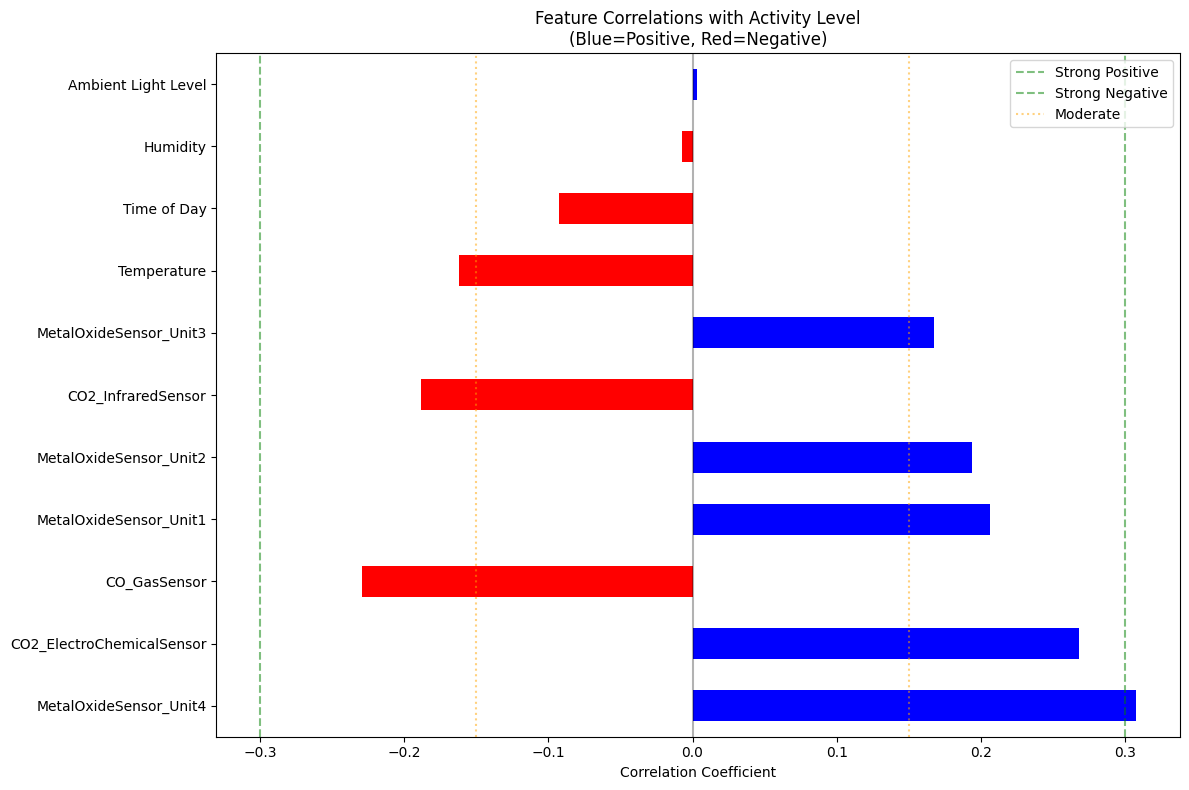

In [15]:
target_encoded = df_clean['Activity Level'].map({
    'Low Activity': 0, 
    'Moderate Activity': 1, 
    'High Activity': 2
})

# Calculate correlations with numerical features
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
correlations = df_clean[numerical_cols].corrwith(target_encoded).sort_values(key=abs, ascending=False)

print("Features ranked by correlation strength with Activity Level:")
for feature, corr in correlations.items():
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.15 else "Weak"
    direction = "Positive" if corr > 0 else "Negative"
    print(f"{feature:25s}: {corr:6.3f} ({strength} {direction})")

# Visualization
plt.figure(figsize=(12, 8))
correlations.plot(kind='barh', color=['red' if x < 0 else 'blue' for x in correlations])
plt.title('Feature Correlations with Activity Level\n(Blue=Positive, Red=Negative)')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0.3, color='green', linestyle='--', alpha=0.5, label='Strong Positive')
plt.axvline(x=-0.3, color='green', linestyle='--', alpha=0.5, label='Strong Negative')
plt.axvline(x=0.15, color='orange', linestyle=':', alpha=0.5, label='Moderate')
plt.axvline(x=-0.15, color='orange', linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Section 6: Features Correlation Matrix

Analyzing correlations for 11 numerical features:
['Time of Day', 'Temperature', 'Humidity', 'CO2_InfraredSensor', 'CO2_ElectroChemicalSensor', 'MetalOxideSensor_Unit1', 'MetalOxideSensor_Unit2', 'MetalOxideSensor_Unit3', 'MetalOxideSensor_Unit4', 'CO_GasSensor', 'Ambient Light Level']


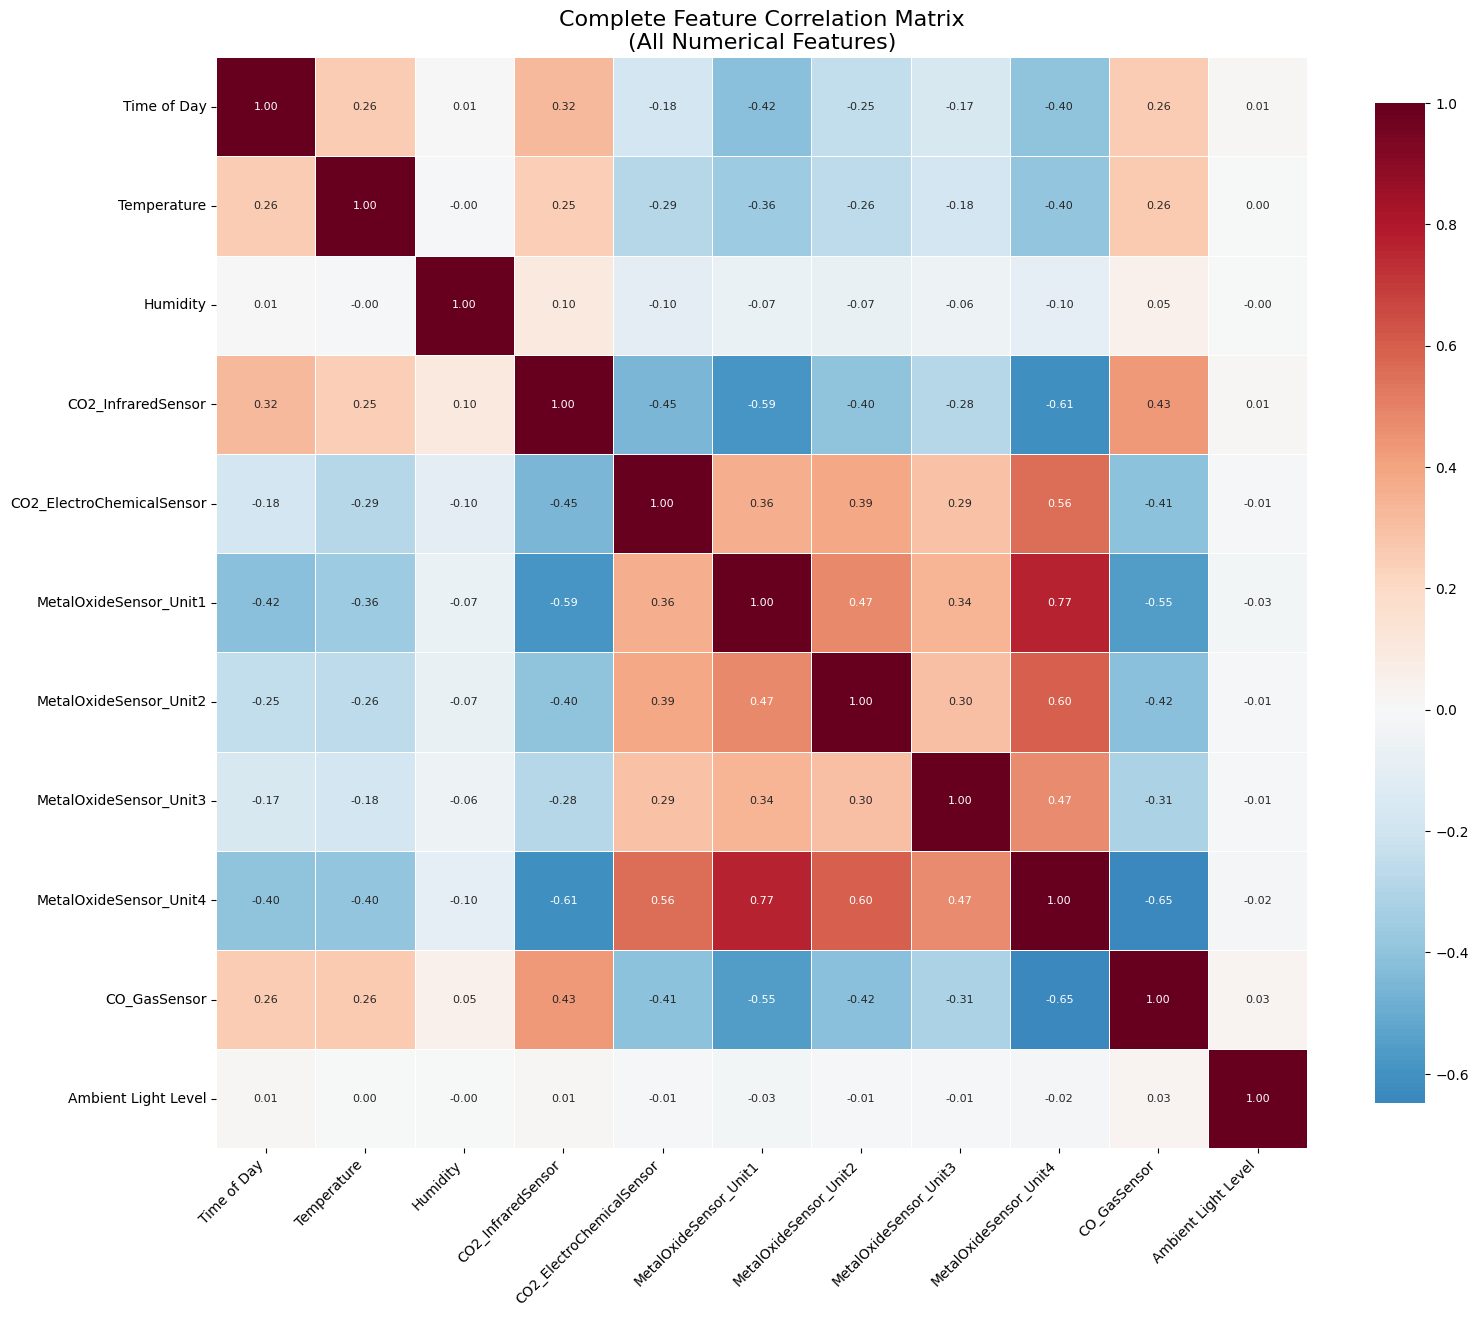

In [21]:
# Get all numerical columns (excluding target)
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'Activity Level' in numerical_cols:
    numerical_cols.remove('Activity Level')

print(f"Analyzing correlations for {len(numerical_cols)} numerical features:")
print(numerical_cols)

# Calculate full correlation matrix
full_corr_matrix = df_clean[numerical_cols].corr()

# Create comprehensive correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(full_corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8},
            linewidths=0.5, annot_kws={'size': 8})
plt.title('Complete Feature Correlation Matrix\n(All Numerical Features)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()